In [33]:
import numpy as np
import pandas as pd
import pickle
import os

from create_sequences import create_sequences
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, LayerNormalization, LeakyReLU, Input

from generate_multivariate_samples import generate_multivariate_samples

import numpy as np
import plotly.graph_objs as go

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [2]:
df_all = pd.read_csv('eua_price_data.csv', thousands=',') 
df_all['Date'] = pd.to_datetime(df_all['Date'], format='%Y-%m-%d')  
df_all = df_all.sort_values(by = 'Date', ascending=True).reset_index(drop = True)
df_all = df_all[(df_all['Date'] > pd.to_datetime('2020-11-24')) & (df_all['Date'] < pd.to_datetime('2024-10-07'))].reset_index(drop=True)

In [3]:
import plotly.express as px
# Assuming df_all is your DataFrame
fig = px.line(df_all, x='Date', y='EUA', title='EUA Over Time')
# Show the figure
fig.show()

In [4]:
from curate_training_test_data import curate_training_test_data

In [31]:
def generate_lstm():
    # Learning rate scheduler function
    def lr_scheduler(epoch, lr):
        # if epoch < 10:
        return lr
        # else:
        #     return lr * np.exp(-0.1)

    model = Sequential()

    # First LSTM layer with LayerNormalization and recurrent dropout
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]),
                activation='tanh', recurrent_activation='sigmoid',
                return_sequences=True, recurrent_dropout=0.2,
                kernel_regularizer=l2(0.001)))
    model.add(LayerNormalization())
    # model.add(Dropout(0.1))

    # Second LSTM layer with residual connection, LayerNormalization, and recurrent dropout
    model.add(LSTM(128, activation='tanh', recurrent_activation='sigmoid',
                return_sequences=True, recurrent_dropout=0.2,
                kernel_regularizer=l2(0.001)))
    model.add(LayerNormalization())
    # model.add(Dropout(0.1))

    # Third LSTM layer (final) without returning sequences, adding residual connection
    model.add(LSTM(256, activation='tanh', recurrent_activation='sigmoid',
                return_sequences=False, recurrent_dropout=0.2,
                kernel_regularizer=l2(0.001)))
    model.add(LayerNormalization())

    # Dense layer with LeakyReLU activation for flexibility in output
    model.add(Dense(len(predictors_lst)))
    model.add(LeakyReLU(alpha=0.1))  # LeakyReLU is more flexible for output regression

    # Compile the model using AdamW optimizer and a learning rate scheduler
    optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)  # AdamW improves generalization
    model.compile(optimizer=optimizer, loss='mse')

    return model


In [34]:
def train_lstm(model, checkpoint_path):
    try:
        model.load_weights(checkpoint_path) 
        with open(os.path.join(checkpoint_path.split('/')[1],checkpoint_path.split('/')[-1].split('.')[0]), 'rb') as f:
            history = pickle.load(f)
    except:

        # Learning rate scheduler callback
        lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

        checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                    monitor='val_loss', 
                                    save_best_only=True,
                                    mode='min',  
                                    verbose=1)

        early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)

        history = model.fit(X_train, y_train, epochs=1000, batch_size=512, 
                            validation_split=0.05,
                            verbose=1, callbacks=[checkpoint, lr_scheduler_callback, early_stopping])# ,early_stopping]) 
        
        with open(os.path.join(checkpoint_path.split('/')[1],checkpoint_path.split('/')[-1].split('.')[0]), 'wb') as f:
            pickle.dump(history, f)


In [30]:
predictors_lst = ['EUA', 'Oil', 'Coal', 'NG', 'USEU', 'S&P_clean', 'DAX']
test_date = '2024-07-01'

folder_name = "new_approach"
modeltype='lstm'

for sequence_length in [7, 14, 28]:

    original_EUA = df_all['EUA'].values  
    dates = df_all['Date'].values
    last_train_date = pd.to_datetime(test_date) - pd.to_timedelta(1, unit = 'day')
    X_train, y_train, X_test, y_test, scaler = curate_training_test_data(df_all, 
                                                                        flatten = False,
                                                                        sequence_length=sequence_length,
                                                                        test_date = test_date,
                                                                        predictors_lst = predictors_lst )

    checkpoint_path = f"./new_approach/{modeltype}_ts_{sequence_length}.keras"

    model = generate_lstm()
    train_lstm(model, checkpoint_path)
    model.load_weights(checkpoint_path) 

    # plot loss curves 
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.savefig(f'{folder_name}/{modeltype}_LossCurve_ts_{sequence_length}.pdf')


    # accuracy plot
    train_predictions = model.predict(X_train, verbose = 0);
    train_predictions_rescaled = scaler.inverse_transform(train_predictions)
    test_predictions = model.predict(X_test, verbose = 0);
    test_predictions_rescaled = scaler.inverse_transform(test_predictions)

    ground_truth_train = scaler.inverse_transform(y_train)
    ground_truth_test = scaler.inverse_transform(y_test)

    plt.figure(figsize = (13,13))
    for i, feature in enumerate(predictors_lst):
        plt.subplot(len(predictors_lst)//3 + 1 if len(predictors_lst)%3 !=0 else len(predictors_lst)//3, 3, i+1)
        plt.scatter(ground_truth_train[:,i],train_predictions_rescaled[:,i], label = 'train')
        plt.scatter(ground_truth_test[:,i],test_predictions_rescaled[:,i], label = 'test')
        plt.plot([min(ground_truth_train[:,i]), max(ground_truth_train[:,i])], 
                [min(ground_truth_train[:,i]), max(ground_truth_train[:,i])], color='red', label='1:1 Line')
        
        r2_train = r2_score(ground_truth_train[:,i],train_predictions_rescaled[:,i])
        r2_test = r2_score(ground_truth_test[:,i],test_predictions_rescaled[:,i])
        plt.title(f"{feature} - train: {r2_train:.5f} / test: {r2_test:.5f}")
        plt.legend()
        plt.grid('on')
        plt.xlabel('ground truth')
        plt.ylabel('prediction')
    plt.tight_layout()
    plt.savefig(f'{folder_name}/{modeltype}_acc_ts_{sequence_length}.pdf')

    # get RMSE:
    rel_erorrs = []
    for i in range(test_predictions_rescaled.shape[1]):
        prediction = test_predictions[:, i]
        ground_truth = y_test[:,i]
        rel_error = np.mean(np.sqrt(((prediction-ground_truth)**2)))
        print(predictors_lst[i])
        print(rel_error)
        rel_erorrs.append(rel_error)


    num_of_prediction = 30*12
    num_ensemble = 10
    rel_erorrs_mat = np.array([rel_erorrs for i in range(num_ensemble)])
    corr = df_all[predictors_lst].corr()
    for factor in [0.5, 1.0, 1.5, 2.0, 3.0, 5.0]:
        next_predictions = []
        current_input = X_train[-1]
        current_input = np.array([current_input for i in range(num_ensemble)]).squeeze()
        for iter_ in tqdm(range(num_of_prediction)):
            next_prediction = model.predict(current_input, verbose = 0)
            error_p = generate_multivariate_samples(corr, n_samples=num_ensemble)
            next_prediction = next_prediction * (1+error_p*rel_erorrs_mat*factor)
            next_predictions.append(next_prediction)
            current_input = np.concatenate([current_input, 
                                            np.expand_dims(next_prediction,1)], axis=1)
        next_predictions = np.array(next_predictions)
        future_dates = [last_train_date + pd.DateOffset(days=i + 1) for i in range(num_of_prediction)]
        ensemble_future_predictions = np.array([scaler.inverse_transform(next_predictions[i]) for i in range(num_of_prediction)])


        # Calculate mean, P10, and P90 of predictions
        mean_predictions = ensemble_future_predictions[:, :, 0].mean(axis=1)
        P50 = np.percentile(ensemble_future_predictions[:, :, 0], 50, axis=1)
        P10 = np.percentile(ensemble_future_predictions[:, :, 0], 10, axis=1)
        P90 = np.percentile(ensemble_future_predictions[:, :, 0], 90, axis=1)

        # Create the plot
        plt.figure(figsize=(10, 6))

        # Plot historical EUA prices
        plt.plot(dates, original_EUA, label='Historical EUA Price', color='black')

        # Plot all realizations
        for realization in ensemble_future_predictions[:, :, 0].T:
            plt.plot(future_dates, realization, color='gray', alpha=0.3)

        # Plot P10 and P90 percentile predictions
        plt.plot(future_dates, P10, label='P10 & P90', color='green', linestyle='-')
        plt.plot(future_dates, P90, color='green', linestyle='-')
        # Plot mean of future predictions
        plt.plot(future_dates, P50, label='Median of Predictions', color='red')
        plt.plot(df_all[df_all['Date']>test_date]['Date'],
                    df_all[df_all['Date']>test_date]['EUA'],
                    color = 'blue',
                    label = 'Future EUA Price' 
                    )


        # Customize the plot
        plt.title('EUA Price Prediction for the Next 24 Months')
        plt.xlabel('Date')
        plt.ylabel('EUA Price')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.savefig(f"{folder_name}/{modeltype}_timeplot_ts_{sequence_length}_factor_{str(factor).replace('.','_')}.pdf")


    record = {}
    with open(f'{folder_name}/{modeltype}_record_ts_{sequence_length}.txt', 'w') as f:
        # report metrics
        for i, feature in enumerate(predictors_lst):
            r2_train = r2_score(ground_truth_train[:,i],train_predictions_rescaled[:,i])
            r2_test = r2_score(ground_truth_test[:,i],test_predictions_rescaled[:,i])
            mse_train = mean_squared_error(ground_truth_train[:,i],train_predictions_rescaled[:,i])
            mse_test  = mean_squared_error(ground_truth_test[:,i],test_predictions_rescaled[:,i])
            mae_train = mean_absolute_error(ground_truth_train[:,i],train_predictions_rescaled[:,i])
            mae_test  = mean_absolute_error(ground_truth_test[:,i],test_predictions_rescaled[:,i])
            f.write(f'{feature}\n')
            f.write(f'r2(train): {r2_train}\n')
            f.write(f'r2(test): {r2_test}\n')
            f.write(f'mse(train): {mse_train}\n')
            f.write(f'mse(test): {mse_test}\n')
            f.write(f'mae(train): {mae_train}\n')
            f.write(f'mae(test): {mae_test}\n')
            f.write('---------------------------\n')
            record['feature'] = {"r2_train":r2_train, 
                                "r2_test": r2_test,
                                "mse_train": mse_train, 
                                "mse_test": mse_test, 
                                "mae_train": mae_train, 
                                "mae_test": mae_test,}
    # save metric as dictionary
    with open(f'{folder_name}/{modeltype}_record_ts_{sequence_length}.pkl', 'wb') as f:
        pickle.dump(record, f)
    # Save the best model
    with open(f'{folder_name}/{modeltype}_bestmodel_ts_{sequence_length}.pkl', 'wb') as f:
        pickle.dump(model, f)
    with open(f'{folder_name}/{modeltype}_bestmodel_params_ts_{sequence_length}.pkl', 'wb') as f:
        pickle.dump(best_params, f)


Epoch 1/1000


c:\Users\kangs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

c:\Users\kangs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1.6173
Epoch 1: val_loss improved from inf to 0.62623, saving model to ./new_approach/lstm_ts_7.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - loss: 1.5795 - val_loss: 0.6262 - learning_rate: 0.0010
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.8569
Epoch 2: val_loss improved from 0.62623 to 0.47841, saving model to ./new_approach/lstm_ts_7.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.8535 - val_loss: 0.4784 - learning_rate: 0.0010
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.7508 
Epoch 3: val_loss improved from 0.47841 to 0.47026, saving model to ./new_approach/lstm_ts_7.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.7491 - val_loss: 0.4703 - learning_rate: 0.0010
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.6999
Epoch 4: val_loss improved from 0.47026 to 0.44795, saving model to ./new_approach/lstm_ts_7.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.6966 - val_loss

100%|██████████| 360/360 [00:32<00:00, 10.96it/s]


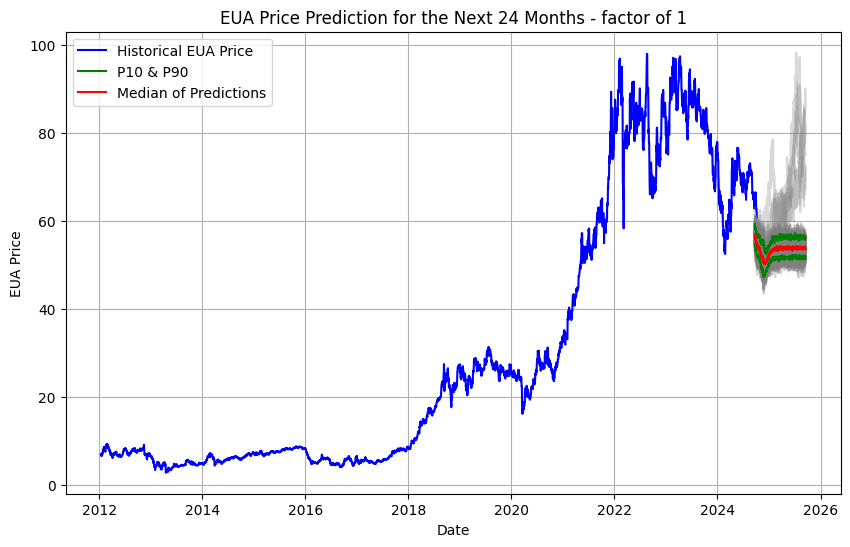

100%|██████████| 360/360 [00:31<00:00, 11.29it/s]


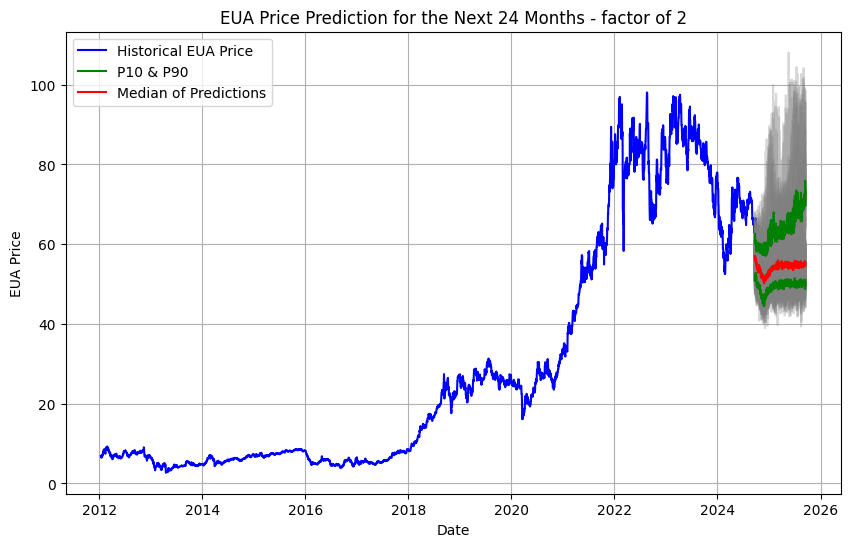

100%|██████████| 360/360 [00:30<00:00, 11.73it/s]


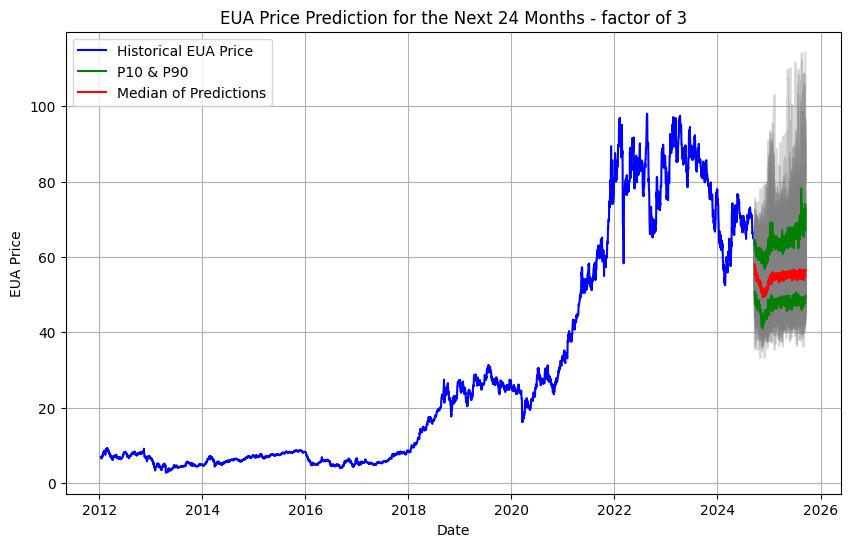

In [18]:
for factor in [1, 2, 3]:
    num_of_prediction = 30*12
    num_ensemble = 100
    rel_erorrs_mat = np.array([rel_erorrs for i in range(num_ensemble)])
    corr = df_all[predictors_lst].corr()

    next_predictions = []
    current_input = train_predictions[-sequence_length:, :]
    current_input = np.array([current_input for i in range(num_ensemble)]).squeeze()
    for iter_ in tqdm(range(num_of_prediction)):
        next_prediction = model.predict(current_input, verbose = 0)
        error_p = generate_multivariate_samples(corr, n_samples=num_ensemble)
        next_prediction = next_prediction * (1+error_p*rel_erorrs_mat*factor)
        next_predictions.append(next_prediction)
        current_input = np.concatenate([current_input[:,1:], 
                                        next_prediction.reshape(next_prediction.shape[0],1,
                                                                next_prediction.shape[1])], axis=1)
    next_predictions = np.array(next_predictions)
    future_dates = [pd.to_datetime(train_dates[-1]) + pd.DateOffset(days=i + 1) for i in range(num_of_prediction)]
    ensemble_future_predictions = np.array([scaler.inverse_transform(next_predictions[i]) for i in range(num_of_prediction)])
    # Calculate mean, P10, and P90 of predictions
    mean_predictions = ensemble_future_predictions[:, :, 0].mean(axis=1)
    P50 = np.percentile(ensemble_future_predictions[:, :, 0], 50, axis=1)
    P10 = np.percentile(ensemble_future_predictions[:, :, 0], 10, axis=1)
    P90 = np.percentile(ensemble_future_predictions[:, :, 0], 90, axis=1)

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot historical EUA prices
    plt.plot(dates, original_EUA, label='Historical EUA Price', color='blue')

    # Plot all realizations
    for realization in ensemble_future_predictions[:, :, 0].T:
        plt.plot(future_dates, realization, color='gray', alpha=0.3)

    # Plot P10 and P90 percentile predictions
    plt.plot(future_dates, P10, label='P10 & P90', color='green', linestyle='-')
    plt.plot(future_dates, P90, color='green', linestyle='-')
    # Plot mean of future predictions
    plt.plot(future_dates, P50, label='Median of Predictions', color='red')


    # Customize the plot
    plt.title(f'EUA Price Prediction for the Next 24 Months - factor of {factor}')
    plt.xlabel('Date')
    plt.ylabel('EUA Price')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.show()

In [14]:
num_of_prediction = 30*24
num_ensemble = 3

ensemble_future_predictions = []
for en in range(num_ensemble):
    future_predictions = []
    current_input = train_predictions[-sequence_length:, :]
    for i in tqdm(range(num_of_prediction)):
        current_input_scaled = np.reshape(current_input, (1, sequence_length, current_input.shape[1]))
        next_prediction = model.predict(current_input_scaled, verbose = 0)
        for j in range(train_predictions_rescaled.shape[1]):
            next_prediction[0, j] *= (1+np.random.normal(0, rel_erorrs[j]))
        future_predictions.append(next_prediction[0])  
        current_input = np.concatenate([current_input[1:], [next_prediction[0]]], axis=0)
    ensemble_future_predictions.append(scaler.inverse_transform(np.array(future_predictions)))

ensemble_future_predictions= np.array(ensemble_future_predictions)


# future_predictions_original = scaler.inverse_transform(future_predictions)
future_dates = [pd.to_datetime(train_dates[-1]) + pd.DateOffset(days=i + 1) for i in range(num_of_prediction)]

 73%|███████▎  | 524/720 [00:30<00:11, 17.45it/s]


KeyboardInterrupt: 

In [55]:

# Create traces for each plot
trace1 = go.Scatter(x=dates, y=original_EUA, mode='lines', name='Historical EUA Price', 
                    line=dict(color='blue'))

trace2 = go.Scatter(x=future_dates, y=ensemble_future_predictions[0,:,0], mode='lines', 
                    name='Predicted EUA Price_1', 
                    line=dict(color='red'))

trace3 = go.Scatter(x=future_dates, y=ensemble_future_predictions[1,:,0], mode='lines', 
                    name='Predicted EUA Price_2', 
                    line=dict(color='purple'))

trace4 = go.Scatter(x=future_dates, y=ensemble_future_predictions[2,:,0], mode='lines', 
                    name='Predicted EUA Price_3', 
                    line=dict(color='orange'))

trace5 = go.Scatter(x=train_dates[-train_predictions_rescaled.shape[0]:], 
                    y=train_predictions_rescaled[:, 0], mode='lines+markers', 
                    name='Train Predicted EUA Price', marker=dict(color='green', size=4), 
                    line=dict(color='green'))

# Layout for the plot
layout = go.Layout(
    title='EUA Price Prediction for the Next 24 Months',
    xaxis=dict(title='Date'),
    yaxis=dict(title='EUA Price'),
    legend=dict(x=0, y=1, traceorder='normal'),
    height=600,
    width=1000
)

# Create the figure with the traces
fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5], layout=layout)

# Show the figure (interactive plot)
fig.show()

C:\Users\kangs\AppData\Local\Temp\ipykernel_30712\3608131112.py:7: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.



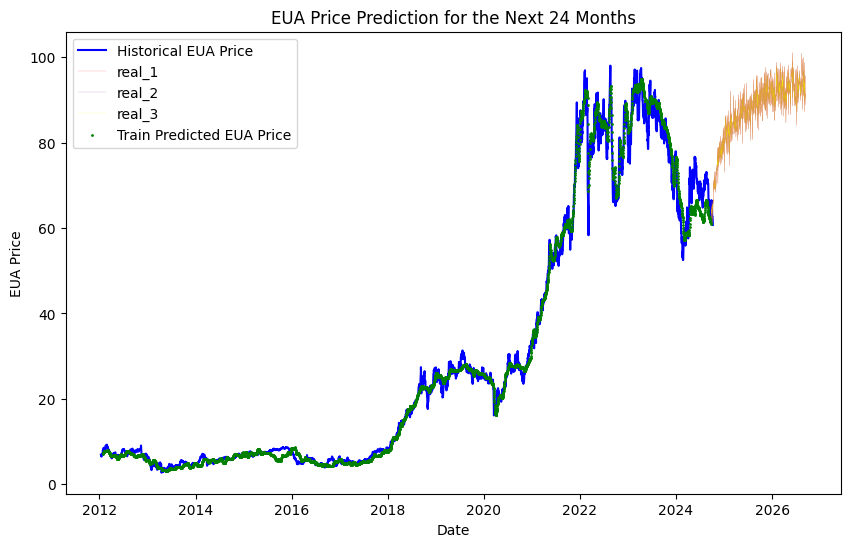

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(dates, original_EUA, 'b', label='Historical EUA Price')  # 원본 EUA 데이터
# plt.plot(train_dates, scaler.inverse_transform(test_data_scaled)[:, 0], 'skyblue', label='Test EUA Price')  # 테스트 데이터
plt.plot(future_dates, ensemble_future_predictions[0, :, 0].T, 'red', linewidth = 0.1, label = 'real_1')
plt.plot(future_dates, ensemble_future_predictions[0, :, 0].T, 'purple', linewidth = 0.1, label = 'real_2')
plt.plot(future_dates, ensemble_future_predictions[0, :, 0].T, 'yellow', linewidth = 0.1, label = 'real_3')
plt.plot(train_dates[-train_predictions_rescaled.shape[0]:], train_predictions_rescaled[:, 0], 'g.', marker='.', markersize=2, label='Train Predicted EUA Price')


plt.xlabel('Date')
plt.ylabel('EUA Price')
plt.title('EUA Price Prediction for the Next 24 Months')
plt.legend()
plt.show()